In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator
from qiskit_aer import AerSimulator
from qutip import basis, mesolve, tensor, Qobj

from util import zero, one, pretty, plot_histogram

# Adiabatic Quantum Computing is Universal

We review Arahnarov et al.'s~[1] result that AQC is **universal**, i.e., every quantum computation can be expressed as an adiabatic computation. 

## Main Idea

The proof works by **reduction**, i.e., by showing that every quantum circuit can be translated to an adiabatic quantum program. This result might be surprising since the result of the computation is encoded in the ground state of the final Hamiltonian which seems to suggest that we need to know the result of the computation in order to construct the final Hamiltonian. Arahnarov et al.'s insight in the translation is to use a **Feynman-Kitaev clock** to encode a final Hamiltonian whose ground state encodes a verification that the circuit is applied correctly.

### Feynman-Kitaev Clock

Suppose we have a quantum circuit $U$ on $n$ qubits comprised of $L$ 2-qubit gates. In symbols,

 $$
 U = U^{L}_{s^L_1, s^L_2} \dots U^{1}_{s^1_1, s^1_2} \dots
 $$
 
 where $U^{j}_{s^j_1, s^j_2}$ means the $j$-th gate is applied to qubits $s^j_1$ and $s^j_2$. The main of the translation is that we will encode a final state which checks that each gate is applied correctly, i.e., the $j$-th gate is applied to the appropriate qubits at the appropriate "time". To keep track of the appropriate time, we thus introduce ancila **clock qubits**. This suggests an encoding of the quantum state $\ket{\psi}$ of

$$
\ket{\psi} = \ket{s_n ... s_1 c_1 ... c_L }
$$

where
1. $\ket{s_n ... s_1}$ are the $n$ qubits encoding the original state of the quantum circuit and
2. $\ket{c_1 ... c_L}$ are $L$ **clock** qubits. $L$ corresponds to the number of gates in $U$.

#### Unary Clock

The clock is a unary representation (most-significant bit is on the right so we have to read from right to left to interpret as a number). We can read the unary clock from left to right. For example, with $L = 2$ we have
- $|00\rangle$ (time 0),
- $|10\rangle$ (time 1), and
- $|11\rangle$ (time 2). 

#### Hamiltonian for Enforcing Unary Clock

We can construct a Hamiltonian $H_{clock}$ that enforces valid clock states as below

\begin{align*}
H_{clock} & = \sum_{i=1}^{L-1} I(\ell-1) \otimes |01\rangle \langle 01| \otimes I(L - \ell - 1)
\end{align*}

where $I(m)$ is an identity matrix on $m$ qubits, i.e., $I(m)$ is a $2^m \times 2^m$ matrix.

In [2]:
def mk_H_clock(L: int) -> np.ndarray:
    if L < 2:
        raise ValueError("L > 2")
    elif L == 2:
        oz = np.kron(zero, one)  # |01>
        return np.outer(oz, oz)  # |01><01|
    else:
        H = np.zeros(2**L)
        oz = np.kron(zero, one)  # |01>
        oz = np.kron(np.outer(oz, oz), np.eye(2**(L - 2)))  # |01><01| \otimes I(L - 2)
        for ell in range(1, L):
            # H += I(\ell-1) \otimes |01><01| \otimes I(L - \ell - 2)
            H += np.kron(np.eye(2**(ell-1)), np.kron(oz, np.eye(2**(L - ell - 1))))
        return H 

H_clock = mk_H_clock(2)
pretty(H_clock)

<IPython.core.display.Latex object>

In [3]:
eigvals, eigs = np.linalg.eigh(H_clock)
print("Energies", eigvals)
idxs = np.argsort(eigvals)
assert eigvals[idxs[-1]] > np.max(eigvals[idxs[:-1]])
pretty(eigs[:, idxs[-1]])

Energies [0. 0. 0. 1.]


<IPython.core.display.Latex object>

We see that all eigenvalues are $0$ except for a single eigenvalue of $1$. This means that the associated state has been penalized relative to the other states has been increased. This forms the main idea of constructing a Hamiltonian to perform a desired computation: penalize unwanted states by increasing their energy. The penalized state in this case is 

$$
\ket{01}
$$

since it violates the unary condition.

In [4]:
# Biggest eigenvectors are illegal states since they have the highest energy
# |state clock_1 clock_2>
pretty(eigs[:, 3])

<IPython.core.display.Latex object>

## Translation

Arahnarov et al. use the Feynamn-Kitaev clock to translate a unitary matrix $U$ and converts it into an adiabatic program $(H_t, T)$. Without loss of generality, we can make two simplifying assumptions.

1. We can construct $H_s$ where $s = t / T$ which scales the time interval from $[0, T]$ to $[0, 1]$.
2. We use the linear interpolation

$$
H_s = (1 - s)H_1 + s H_1 \,.
$$

Thus, given a quantum circuit $U$, we produce $(H_s, T)$.

In [5]:
# Goal in code: write a transpile function that takes a quantum circuit and produces a time-dependent Hamiltonian
def transpile(qc: QuantumCircuit) -> np.ndarray:
    def linear_interpolation(H_0, H_1, T):
        def s(t):
            return t / T
        H_s = [[H_0, lambda t: 1 - s(t)], [H_1, s]]
        return H_s
    
    def mk_H_0(qc):
        raise ValueError("TODO ...")
    
    def mk_H_1(qc):
        raise ValueError("TODO ...")

    def compute_T(qc):
        raise ValueError("TODO ...")

    return linear_interpolation(mk_H_0(qc), mk_H_1(qc), compute_T(qc))

### Example

We'll use an example to illustrate the main ideas of the translation. We use the circuit

$$
U = I H
$$

which applies a Hadamard $H$ followed by an identity $I$ so that we have a $2$ gate circuit that puts a qubit into superposition.

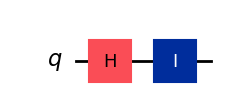

In [6]:
qc = QuantumCircuit(1)
qc.h(0)
qc.id(0)
qc.draw(output="mpl", style="iqp")

### Constructing the Intial Hamiltonian

The initial Hamiltonian $H_0$ is defined as combination of three Hamiltonians

$$
H_0 = I(n) \otimes (H_{\text{clockinit}} + H_{\text{clock}}) + H_\text{input} \,.
$$

The term $ I(n) \otimes (H_{\text{clockinit}} + H_{\text{clock}})$ enforces that the clock is initialized in the starting state and is a unary clock. The term $H_\text{input}$ enforces that the input is initialized correctly, i.e., is $\ket{0^{\otimes n}}$. We'll describe each in turn now.

### H_clockinit

The purpose of

\begin{align*}
H_{clockinit} & = |1\rangle \langle 1| \otimes I(L - 1)
\end{align*}

is to ensure that the clock begins in the appopriate state.

In [7]:
def mk_H_clockinit(L: int) -> np.ndarray:
    return np.kron(np.outer(one, one), np.eye(2**(L - 1)))

H_clockinit = mk_H_clockinit(2)
pretty(H_clockinit)

<IPython.core.display.Latex object>

This penalizes the state $\ket{10}$ and $\ket{11}$ which are the unary states that are not $\ket{00}$. The non-unary states will be penalized by $H_\text{clock}$.

In [8]:
eigvals, eigs = np.linalg.eig(H_clockinit)
print(eigvals)
idxs = np.argsort(eigvals)
assert eigvals[idxs[-1]] > np.max(eigvals[idxs[:-2]])
assert eigvals[idxs[-2]] > np.max(eigvals[idxs[:-2]])

[0.+0.j 0.+0.j 1.+0.j 1.+0.j]


In [9]:
pretty(eigs[:, idxs[-1]])

<IPython.core.display.Latex object>

In [10]:
pretty(eigs[:, idxs[-2]])

<IPython.core.display.Latex object>

#### H_input

The purpose of 

\begin{align*}
H_{input} & = (\sum_{i=1}^n I(i-1) \otimes |1\rangle \langle 1| \otimes I(n - i - 1)) \otimes (|0 \rangle \langle 0| \otimes I(L - 1)) 
\end{align*}

is to ensure that the state qubits are initialized to $\ket{0^{\otimes n}}$ whenever the clock qubits indicate that the clock is in its initial state $\ket{0^{\otimes L}}$.

In [11]:
def mk_H_input(n: int, L: int) -> np.ndarray:
    if n < 1:
        raise ValueError("n >= 1")
    
    op_oo = np.outer(one, one)
    if n == 1:
        state = op_oo
    elif n == 2:
        state = np.kron(np.eye(1), op_oo)
    else:
        state = np.kron(op_oo, np.eye(2**(n - 2)))
        for i in range(2, n):
            state += np.kron(np.eye(2**(i - 1)), np.kron(op_oo, np.eye(2**(n - 2))))

    if L < 2:
        raise ValueError("L > 2")
    else:
        clock = np.kron(np.outer(zero, zero), np.eye(2**(L - 1)))

    return np.kron(state, clock)

H_input = mk_H_input(1, 2)
pretty(H_input)

<IPython.core.display.Latex object>

In [12]:
eigvals, eigs = np.linalg.eig(H_input)
idxs = np.argsort(eigvals)
assert eigvals[idxs[-1]] > np.max(eigvals[idxs[:-2]])
assert eigvals[idxs[-2]] > np.max(eigvals[idxs[:-2]])
eigvals

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 1.+0.j, 0.+0.j, 0.+0.j])

In [13]:
# |state clock_1 clock_2>
pretty(eigs[:, idxs[-1]])

<IPython.core.display.Latex object>

In [14]:
# |state clock_1 clock_2>
pretty(eigs[:, idxs[-2]])

<IPython.core.display.Latex object>

#### Putting it together

We can put all three Hamiltonians together to construct $H_0$.

In [15]:
def mk_H_0(qc: QuantumCircuit) -> np.ndarray:
    n = qc.num_qubits
    L = sum(qc.count_ops().values()) 
    H_clock = mk_H_clock(L)
    H_clockinit = mk_H_clockinit(L)
    H_input = mk_H_input(n, L)
    return np.kron(np.eye(2**n), (H_clockinit + H_clock)) + H_input
    
H_0 = mk_H_0(qc)
pretty(H_0)

<IPython.core.display.Latex object>

The lowest energy state is $\ket{000}$ as desired.

In [16]:
eigvals, eigs = np.linalg.eig(H_0)
print(eigvals)
idxs = np.argsort(eigvals)
assert eigvals[idxs[0]] < np.min(eigvals[idxs[1:]])
#|s_1 c_1 c_0>
pretty(eigs[:, idxs[0]])

[0.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 2.+0.j 1.+0.j 1.+0.j]


<IPython.core.display.Latex object>

### Constructing the Final Hamiltonian

The final Hamiltonian is given as

$$
H_1 = (I(n) \otimes H_\text{clock}) + H_\text{input} + H_\text{propagation} \,.
$$

The final Hamiltonian ensures that
1. the clock is valid throughout the computation (first term),
2. the input of the computation was started in the correct state (second term), and
3. the computation was propagated correctly (third term).

We will cover $H_\text{propagation}$ now.

### Propagation Hamiltonian

The propagation Hamiltonian is defined as

$$
H_\text{propagate} = \frac{1}{2} \sum_{\ell=1}^L \widetilde{H}_{\ell}
$$

where

1.

$$
\widetilde{H}_1 = I \otimes \ket{00}\bra{00}_{1,2} - U^{1}_{s^1_1, s^1_2} \otimes \ket{10}\bra{00}_{1,2} - (U^{1}_{s^1_1, s^1_2}))^\dagger \otimes \ket{00}\bra{10}_{1,2} + I \otimes \ket{10}\bra{10}_{1,2} \,,
$$

2.

$$
\widetilde{H}_{\ell} = I \otimes \ket{100}\bra{100}_{\ell-1,\ell,\ell+1} - U^{\ell}_{s^\ell_1, s^\ell_2} \otimes \ket{110}\bra{100}_{\ell-1,\ell,\ell+1} 
- (U^{\ell}_{s^\ell_1, s^\ell_2})^\dagger \otimes \ket{100}\bra{110}_{\ell-1,\ell,\ell+1} + I \otimes \ket{110}\bra{110}_{\ell-1,\ell,\ell+1} \,,
$$

3. and

$$
\widetilde{H}_L = I \otimes \ket{10}\bra{10}_{L-1,L} - U^{L}_{s^L_1, s^L_2} \otimes \ket{11}\bra{10}_{L-1,L} - (U^{L}_{s^L_1, s^L_2})^\dagger \otimes \ket{10}\bra{11}_{L-1,L} + I \otimes \ket{11}\bra{11}_{L-1,L} \,.
$$

The Hamiltonian checks
1. that the initial and final clock states are valid and
2. that each gate and its reverse is applied in the appropriate order.

In [17]:
def mk_H_propagate(qc: QuantumCircuit):
    n = qc.num_qubits
    L = sum(qc.count_ops().values()) 
    
    zz = np.kron(zero, zero)
    oz = np.kron(one, zero)
    oo = np.kron(one, one)
    I = np.eye(2**n)

    def gate_to_operator(ell):
        gate_data = qc.data[ell]
        gate = gate_data[0]
        return Operator(gate).data

    U = gate_to_operator(0)
    U_d = np.conjugate(U).T
    H = np.kron(I, np.outer(zz, zz)) - np.kron(U, np.outer(oz, zz)) - np.kron(U_d, np.outer(zz, oz)) + np.kron(I, np.outer(oz, oz))
    for ell in range(1, L):
        U = gate_to_operator(ell)
        U_d = np.conjugate(U).T
        if ell == L - 1:
            H += np.kron(I, np.outer(oz, oz)) - np.kron(U, np.outer(oo, oz)) - np.kron(U_d, np.outer(oz, oo)) + np.kron(I, np.outer(oo, oo))
        else:
            pass
    return 0.5 * H

H_propagate = mk_H_propagate(qc)
pretty(H_propagate)

/var/folders/4y/c1cn6w0n0_b0s21cb4cb4tp80000gn/T/ipykernel_62069/1635389874.py:12: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  gate = gate_data[0]


<IPython.core.display.Latex object>

#### Putting it together

We can now construct

$$
H_1 = (I(n) \otimes H_\text{clock}) + H_\text{input} + H_\text{propagation} \,.
$$

In [18]:
def mk_H_1(qc):
    n = qc.num_qubits
    L = sum(qc.count_ops().values()) 

    H_clock = mk_H_clock(L)
    H_input = mk_H_input(n, L)
    H_propagate = mk_H_propagate(qc)
    return np.kron(np.eye(2**n), H_clock) + H_input + H_propagate

H_1 = np.kron(np.eye(2), H_clock) + H_input + H_propagate
pretty(H_1)

<IPython.core.display.Latex object>

In [19]:
eigvals, eigs = np.linalg.eig(H_1)

# Get the ground state
idxs = np.argsort(eigvals)
assert eigvals[idxs[0]] < np.min(eigvals[idxs[1:]])
pretty(eigs[:, idxs[0]])

<IPython.core.display.Latex object>

#### Post-selection

The final quantum state contains a history of the computation.

1. The initial state $\ket{000}$ occurs with probability $1/3$.
2. The state after the application of the $H$ is $\frac{\sqrt{6}}{6}\ket{010} + \frac{\sqrt{6}}{6}\ket{110}$ occurs with probability $1/3$.
3. The final state after the application of the identity is $\frac{\sqrt{6}}{6}\ket{011} + \frac{\sqrt{6}}{6}\ket{111}$ which occurs with probability $1/3$.

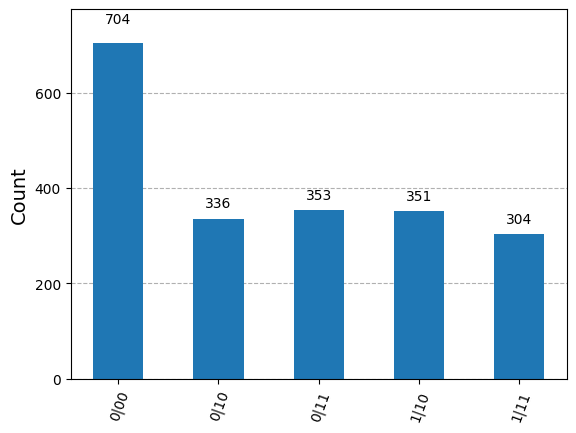

In [20]:
def histogram_final_state(final_state):
    qc_extract = QuantumCircuit(3, 3)
    qc_extract.initialize(final_state)
    qc_extract.measure(range(3), range(3))
    results = AerSimulator().run(qc_extract, shots=2048).result()
    answer = results.get_counts()
    answer = {f"{k[0]}|{k[1:]}": v for k, v in answer.items()}
    return answer

plot_histogram(histogram_final_state(eigs[:, idxs[0]]))

## Adiabatic Evolution

We can now put all the pieces to perform the adiabatic evolution

$$
\text{GroundState}(H_0) \rightarrow \text{GroundState}(H_1) \,.
$$

In essense, we linearly evolve $H_{clockinit}$ to $H_{propagate}$ since $H_{input}$ and $H_{clock}$ are constant.

\begin{align*}
H(s) & = (1 - s)H_{init} + sH_{final} \\
& = H_{init} + s(H_{final} - H_{init}) \\
& = H_{init} + s(H_{input} + H_{clock} + H_{l sum} - (H_{input} + H_{clock} + H_{clockinit})) \\
& = H_{init} + s(H_{l sum} - H_{clockinit}) \\
& = H_{input} + H_{clock} + H_{clockinit} + s(H_{l sum} - H_{clockinit}) \\
& = H_{input} + H_{clock} + (1 - s)H_{clockinit} + sH_{l sum} \\
\end{align*}

In [21]:
def compute_T(qc):
    # T = L^6 for 5-local translation.
    L = sum(qc.count_ops().values())
    return L**6

def transpile(qc: QuantumCircuit) -> np.ndarray:
    def linear_interpolation(H_0, H_1, T):
        def s(t):
            return t / T
        H_s = [[H_0, lambda t: 1 - s(t)], [H_1, s]]
        return H_s

    return linear_interpolation(
        Qobj(mk_H_0(qc), dims=[[2, 2, 2], [2, 2, 2]]),
        Qobj(mk_H_1(qc), dims=[[2, 2, 2], [2, 2, 2]]),
        compute_T(qc)
    )

T = compute_T(qc)
times = np.linspace(0, T, 500)
z = basis(2, 0)
result = mesolve(transpile(qc), tensor(z, tensor(z, z)), times, [], [])
pretty(result.final_state)

/var/folders/4y/c1cn6w0n0_b0s21cb4cb4tp80000gn/T/ipykernel_62069/1635389874.py:12: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  gate = gate_data[0]


<IPython.core.display.Latex object>

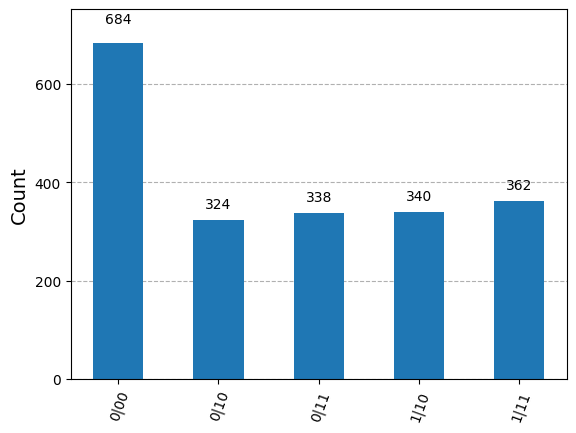

In [22]:
final_state_p = Statevector(result.final_state.full()) 
plot_histogram(histogram_final_state(final_state_p))

## Summary

1. We saw that adiabatic quantum computation is universal.
2. We reviewed the main idea of the proof based on the Feynman-Kitaev clock via example.

## References

[1] (Adiabatic Quantum Computation is Equivalent to Standard Quantum Computation)[https://arxiv.org/pdf/quant-ph/0405098]